In [1]:
#Installing required libraries
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

(16000,) 16000


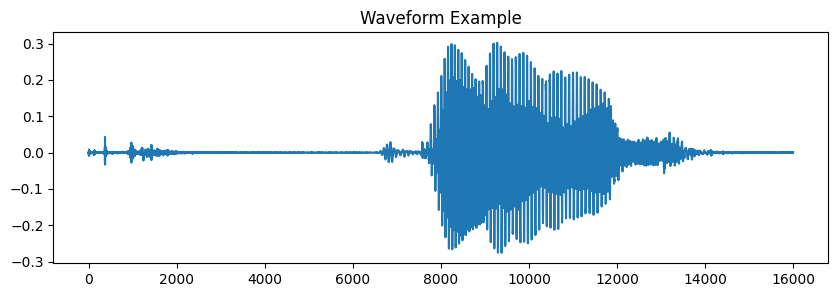

In [17]:
#Load multiple audio files + Extract MFCC Features
file_path = "../data/bird/0a7c2a8d_nohash_0.wav"

y, sr = librosa.load(file_path, sr=16000)
print(y.shape, sr)

plt.figure(figsize=(10,3))
plt.plot(y)
plt.title("Waveform Example")
plt.show()

In [30]:
def extract_features(file_path, sr=16000, n_mfcc=40):
    y, _ = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # (n_mfcc, time)
    mfcc = mfcc.T  # now shape = (time, n_mfcc)
    return mfcc

In [31]:
data_dir = "../data"

X = []
y = []

class_labels = os.listdir(data_dir)

for label in class_labels:
    class_path = os.path.join(data_dir, label)

    if not os.path.isdir(class_path):
        continue

    for file in os.listdir(class_path):
        if file.endswith(".wav"):
            file_path = os.path.join(class_path, file)
            features = extract_features(file_path)
            X.append(features)
            y.append(label)

print("Loaded files:", len(X))


Loaded files: 610


In [32]:
max_len = max([f.shape[0] for f in X])  # longest MFCC time length
print("Max sequence length:", max_len)

X_padded = pad_sequences(
    X,
    maxlen=max_len,
    padding='post',
    dtype='float32'
)

X_padded = np.array(X_padded)
y = np.array(y)

print("Feature matrix:", X_padded.shape)
print("Labels:", y.shape)


Max sequence length: 32
Feature matrix: (610, 32, 40)
Labels: (610,)


In [33]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y_onehot,
    test_size=0.2,
    random_state=42,
    stratify=y_onehot
)


In [35]:
model = Sequential()

# Block 1
model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same',
                 input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))

# Block 2
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.3))

# Block 3
model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.3))

# Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

# Output layer
model.add(Dense(y_onehot.shape[1], activation='softmax'))

model.summary()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 32, 32)         │         3,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 16, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 16, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 8, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,731 (397.39 KB)

 Trainable params: 101,283 (395.64 KB)

 Non-trainable params: 448 (1.75 KB)

In [36]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [37]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=32,
    verbose=1
)

Epoch 1/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.3770 - loss: 1.8504 - val_accuracy: 0.3689 - val_loss: 1.2740
Epoch 2/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4016 - loss: 1.6170 - val_accuracy: 0.4836 - val_loss: 0.9855
Epoch 3/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5102 - loss: 1.2582 - val_accuracy: 0.6148 - val_loss: 0.8767
Epoch 4/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5553 - loss: 1.1751 - val_accuracy: 0.6311 - val_loss: 0.8447
Epoch 5/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6189 - loss: 0.9836 - val_accuracy: 0.6475 - val_loss: 0.8081
Epoch 6/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6660 - loss: 0.9178 - val_accuracy: 0.6967 - val_loss: 0.7417
Epoch 7/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6721 - loss: 0.8904 - val_accuracy: 0.7213 - val_loss: 0.6880
Epoch 8/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7070 - loss: 0.7437 - val_accuracy: 0.7295 - val_loss

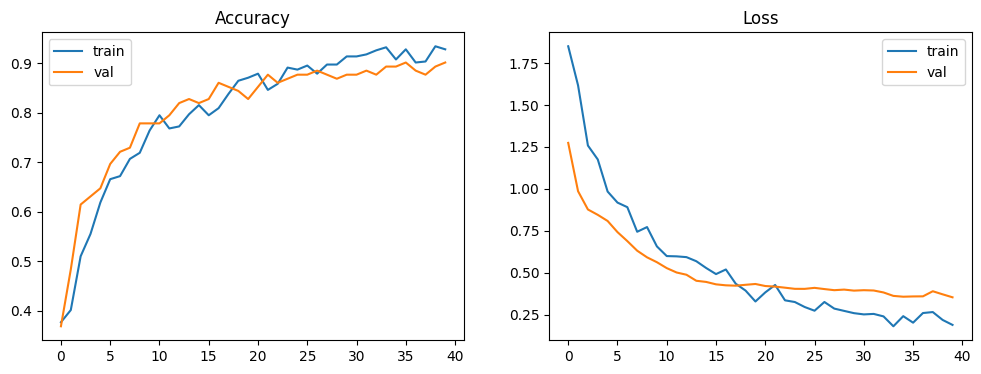

In [39]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(['train','val'])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(['train','val'])

plt.show()

In [40]:
def predict_audio(file_path):
    mfcc = extract_features(file_path)
    mfcc = pad_sequences([mfcc], maxlen=max_len, padding='post', dtype='float32')
    pred = model.predict(mfcc)
    index = np.argmax(pred)
    return encoder.classes_[index]

In [43]:
test_file = "../data/dog/1c3f4fac_nohash_1.wav"
print("Prediction:", predict_audio(test_file))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Prediction: dog


In [44]:
test_file = "../data/bird/2b42e7a2_nohash_0.wav"
print("Prediction:", predict_audio(test_file))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Prediction: bird


In [46]:
test_file = "../data/cat/38c30a4a_nohash_0.wav"
print("Prediction:", predict_audio(test_file))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction: cat
